# 9. Data analysis

After manually reviewing all entries marked as positive and a representative sample of the entries marked as negative, I feel confident enough to start doing some proper data analysis.

#### Importing packages

In [1]:
import pandas as pd
import json
import glob
import geopandas as gpd
import json
import os
%matplotlib inline

#### Data

In [2]:
df = pd.read_csv("../output/dataset/complete-data-classified.csv")

#### Configs

In [3]:
pd.set_option('display.max_rows', 500)

## How many results do we have?

In [4]:
df.shape[0]

20561

## Checking collection succesfulness rate

How many valid search results do we have for each country?

Notice that the countries of Dominica and Dominican Republic had the same reuslts, since they were produced by the same search query ("dominican women")

In [5]:
df.groupby("search_query").search_query.count()

search_query
afghan women                100
albanian women              100
algerian women              100
american women              100
andorran women              100
angolan women               100
antiguan women              100
argentinian women           100
armenian women              100
australian women            100
austrian women              100
azerbaijani women           100
bahamian women              100
bahraini women              100
bangladeshi women           100
barbadian women             100
basotho women               100
belarusian women            100
belgian women               100
belizean women              100
beninese women              100
bermudian women             100
bhutanese women             100
bissau-guinean women        100
bolivian women              100
bosnian women               100
botswanan women             100
brazilian women             100
british women               100
bruneian women              100
bulgarian women            

How many images were succesfully downloaded for each nation?

In [6]:
df.groupby("search_query").img_path.count().sort_values(ascending=False)

search_query
congolese women             198
dominican women             196
zimbabwean women            100
kazakhstani women           100
portuguese women            100
pakistani women             100
northern irish women        100
myanma women                100
monacan women               100
mauritian women             100
mauritanian women           100
marshallese women           100
maldivian women             100
macedonian women            100
laos women                  100
iranian women               100
iraqi women                 100
south sudanese women        100
haitian women               100
french women                100
eritrean women              100
english women               100
egyptian women              100
chinese women               100
bosnian women               100
bhutanese women             100
belizean women              100
andorran women              100
samoan women                100
afghan women                100
tongan women               

And how many title tags were succesfully retrieved?

In [7]:
df.groupby("search_query").full_title.count().sort_values(ascending=False)

search_query
congolese women             196
dominican women             196
afghan women                100
honduran women              100
north korean women          100
new zealand women           100
south african women         100
south korean women          100
sudanese women              100
surinamese women            100
zambian women               100
kosovar women               100
samoan women                100
iranian women               100
togolese women              100
ivorian women               100
puerto rican women          100
chinese women               100
burkinabé women             100
botswanan women             100
american women              100
belizean women              100
myanma women                 99
polish women                 99
papua new guinean women      99
palestinian women            99
northern irish women         99
algerian women               99
australian women             99
bangladeshi women            99
nepalese women             

How many entries have both images and titles succesfully extracted, by country?

In [8]:
df[~(df.img_path.isna()) & ~(df.full_title.isna())].groupby("search_query").img_path.count().sort_values(ascending=False)

search_query
congolese women             194
dominican women             192
afghan women                100
belizean women              100
chinese women               100
samoan women                100
togolese women              100
iranian women               100
myanma women                 99
south korean women           99
south african women          99
northern irish women         99
north korean women           99
iraqi women                  99
kosovar women                99
ivorian women                99
syrian women                 99
honduran women               99
egyptian women               99
botswanan women              99
bangladeshi women            99
sri lankan women             99
zimbabwean women             99
basotho women                98
tanzanian women              98
bosnian women                98
marshallese women            98
maltese women                98
portuguese women             98
maldivian women              98
yemeni women               

Notice that 'congolese women'  and 'dominican women' have more than 100 entries because the queries refer to nations with similar names: Congo, Congo DR, Dominica and Dominican Republic.

## Quantifying racy imagery

First, let's determine how many images we have in total and how many were tagged as racy.

In [9]:
def quantify(df, eval_col, conditions, descriptions):
    '''
    Prints how many rows of the dataframe met
    each specified condition and their human-
    readable descrpitions.
    
    Parameteres:
    
    df -> A pandas daframe
    eval_col -> The column which will be evaluated
    condition -> A lambda function to be applied in that column, which will return either True or False
    description -> A human-language description of the condition checked
    '''
    
    assert len(conditions) == len(descriptions)
    
    for condition, description in zip(conditions, descriptions):
        
        df["condition_bool"] = df[eval_col].apply(condition)
        count = df[df.condition_bool].shape[0]
        
        print(f"{count} {description}")

In [10]:
quantify(df=df, 
         eval_col="racy_bool", 
         conditions=[lambda x: x is True, lambda x: x is False], # This checks the value in the boolean column
         descriptions=["rows have racy images", "rows don't have racy images"])

2057 rows have racy images
18504 rows don't have racy images


Here, I will not use the manual validation I did, since it's as subjective and unreliable as using the computer vision API. However, after looking at each one of the pictures marked as positive, I noticed some patterns that must be considered when analyzing the API resutls.

- Although the Cloud Vision API returned a significant rate of false positives, which were more likely to happen in Africa and Oceania, the rates were significantly lower on Latin America and Eastern Europe.


- Protests such as the slut walk are often tagged as racy.

- Traditional african clothing, such as seen in Namibia, Sierra Leone and Swaziland, are likely to be tagged as racy.

- Pregnancy, couples and breast-feeding can also trigger false positives.

- The API has a tendency of tagging sitted people (specially when non-western women) as racy.

- Athletes in short clothing (running outfits, swimming outfits) are likely to be marked as racy.

- False negatives seem to be rare, which makes sense, since the results come from a content filtering soluting, for which the incentives are to not let anything pass -- even is this may come at the cost of more false positives.

This being said, let's take a look at the countries that have a higher percentage of images tagged as racy.

In [11]:
def get_percentages(df, eval_col, condition, group_col=None, join_cols=None, normalize=True, zeroes=True):
    '''
    Gets the ammount of rows in a dataframe
    that meet a given condition, with
    additional support for groupbys.
    
    Parameters:
    
    df -> The pandas daframe to be aggregated
    eval_col -> The column whose value will be evaluated.
    condition -> A boolean lambda funcion that will be applied to the values of the evaluate_column
    group_col -> The columns by which the dataframe can be grouped by. Optional.
    join_cols -> Whether or not the resulting dataframe should be joined with other informative columns
    normalize -> Pass 'False' to have an absolute count instead
    dropna -> Whether or not an counts should be included in the resutling dataframe
    zeroes -> Whether or not the resulting dataframe should include countries with zero value counts for the condition
    '''

    if group_col:
                    
            percentages = (df.set_index(group_col)
                           [eval_col]
                           .apply(condition)
                           .groupby(level=0)
                           .value_counts(normalize=normalize)
                           .to_frame()
                           .rename(columns={eval_col: f'percentage_{eval_col}'})
                           .reset_index())

            percentages = percentages[percentages[eval_col]==True].reset_index(drop=True)
            percentages = percentages.drop(columns=eval_col)
            percentages = percentages.sort_values(by=f'percentage_{eval_col}', ascending=False)

        
    else:
        
        percentages = (df[eval_col]
                       .apply(condition)
                       .value_counts(normalize=normalize)
                       .to_frame()
                       .rename(columns={eval_col: f'percentage_{eval_col}'})
                       .reset_index()
                       .rename(columns={'index': 'bool'}))
        
        percentages = percentages[percentages['bool']==True].reset_index(drop=True)
        percentages = percentages.drop(columns='bool')
        
        
    if zeroes:
        
        zero_count_items = df[~df[group_col].isin(percentages[group_col])]
        zero_count_items = zero_count_items[group_col].unique()
        
        zero_count_items =  [ {   group_col: item,
                                  f"percentage_{eval_col}": 0
                              } for item in zero_count_items ]
        
        zero_count_items = pd.DataFrame(zero_count_items)
        
        percentages = pd.concat([percentages, zero_count_items])
        
        
    if join_cols:
        
        join_cols.append(group_col)
        
        info = (df.drop_duplicates(subset=group_col)
               [join_cols])
        
        percentages = percentages.merge(info, on=group_col, how='left')
        

        
    return percentages

#### All countries
Below, we will take a look at the countries that have a higher rate of racy pictures, considering all the world.

In [12]:
safesearch = get_percentages(df, 
                eval_col='racy_bool', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area',
                join_cols=['iso_a3'])

display(safesearch)

,country_or_area,percentage_racy_bool,iso_a3
0,Dominica,0.41,DMA
1,Dominican Republic,0.41,DOM
2,Brazil,0.41,BRA
3,Costa Rica,0.40,CRI
4,Trinidad and Tobago,0.40,TTO
5,Belize,0.36,BLZ
6,Colombia,0.34,COL
7,Jamaica,0.32,JAM
8,Cabo Verde,0.32,CPV
9,Uruguay,0.28,URY


There are 26 countries that have a racy picture occurence rate of at least 20%. 19 of them are from Latin America and the Caribbean, 3 are from Eastern Europe (including Greece in that definition), 1 is from Northern Europe and 2 are from Africa. Of the latter, one is Namibia, which is only there because the SafeSearch algorithm recognizes traditional Himba clothing as racy.

Let's plot that into a world map. Notice that some of the results will be discarded, as only sovereing countries will be kept when plotting -- that is, we won't see results for queries such as 'english women' or 'puerto rican women'.

In [13]:
def plot_map(df, valcol, plot_no_data=True):
    '''
    Plots a world map using geopandas and
    a simple df with a country code-value mapping.
    '''
    
    
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        
    # Corrects some missing codes
    world_map.loc[21, 'iso_a3'] = 'NOR'
    world_map.loc[43, 'iso_a3'] = 'FRA'
    world_map.loc[174, 'iso_a3'] = 'KOS'

    
    world_map = world_map.merge(df, on='iso_a3', how='left')
    
    if plot_no_data:
        ax = world_map[world_map[valcol].isna()].plot(color='gray', figsize=(12,8))

        world_map[~world_map[valcol].isna()].plot(cmap='RdPu', column=valcol, ax=ax)
        
    else:
        ax = world_map[~world_map[valcol].isna()].plot(cmap='RdPu', column=valcol, figsize=(12,8))
    
    #display(world_map[world_map[valcol].isna()])


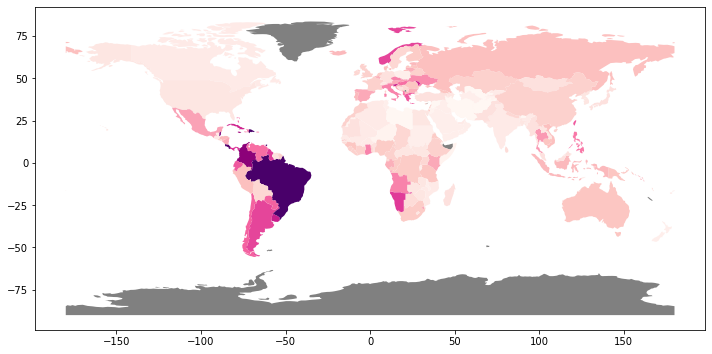

In [14]:
plot_map(safesearch, 'percentage_racy_bool')

#### Continetal sub-regions

Let's see if a similar pattern holds up when we group those countries by region.

In [15]:
get_percentages(df, 
                eval_col='racy_bool', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='sub_region_name')

,sub_region_name,percentage_racy_bool
4,Latin America and the Caribbean,0.206000
3,Eastern Europe,0.142000
13,Southern Europe,0.131333
9,Northern Europe,0.092143
11,South-eastern Asia,0.090000
8,Northern America,0.085000
5,Melanesia,0.080000
14,Sub-Saharan Africa,0.078333
6,Micronesia,0.078000
2,Eastern Asia,0.077143


Apparently, it does. Latin American women are the most sexualized, followed by Eastern and Southern European women. However, it's possible that the sexualization rates within those regions varies. Let's zoom in.

#### Latin american countries

In [16]:
latam = get_percentages(df[df.sub_region_name=="Latin America and the Caribbean"], 
                eval_col='racy_bool', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area',
                join_cols=['iso_a3'])

display(latam)

,country_or_area,percentage_racy_bool,iso_a3
0,Dominica,0.41,DMA
1,Brazil,0.41,BRA
2,Dominican Republic,0.41,DOM
3,Costa Rica,0.40,CRI
4,Trinidad and Tobago,0.40,TTO
5,Belize,0.36,BLZ
6,Colombia,0.34,COL
7,Jamaica,0.32,JAM
8,Uruguay,0.28,URY
9,Cuba,0.27,CUB


#### Eastern european countries

In [17]:
eastern_europe = get_percentages(df[df.sub_region_name=="Eastern Europe"], 
                eval_col='racy_bool', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area',
                join_cols=['iso_a3'])

display(eastern_europe)

,country_or_area,percentage_racy_bool,iso_a3
0,Republic of Moldova,0.27,MDA
1,Hungary,0.20,HUN
2,Czechia,0.18,CZE
3,Ukraine,0.17,UKR
4,Slovakia,0.16,SVK
5,Bulgaria,0.13,BGR
6,Russian Federation,0.11,RUS
7,Romania,0.10,ROU
8,Belarus,0.08,BLR
9,Poland,0.02,POL


One interesting thing to notice here is that Poland women are often portrayed in their marches against a new anti-abortion law.

#### Southern European countries

In [18]:
get_percentages(df[df.sub_region_name=="Southern Europe"], 
                eval_col='racy_bool', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_racy_bool
13,Slovenia,0.28
4,Greece,0.22
0,Albania,0.19
5,Italy,0.18
7,Malta,0.16
1,Andorra,0.15
3,Croatia,0.14
14,Spain,0.14
9,North Macedonia,0.12
10,Portugal,0.12


Notice that some countries labeled as southern europe could be considered as eastern european according to some definitions, like Slovenia, Greece, Albania, Croatia, North Macedonia, Serbia and Montenegro.

# Sexualized hiperlinks

For this analysis, I will remove the false positives that I found -- that is, titles that include words associated with sexualizing content, but that don't promote such views. Examples are mostly of news events: a decree by the King of Swaziland ordering men to marry two wives; UN reports about child marriage in developing countries; a sex strike in Togo; a hoax about Iceland's government paying foreign men to marry Icelandinc women...

In [19]:
def get_keywords_manual_check(row):
    '''
    Fetches the manual classificaiton of site
    contents that we did before, in order to get
    rid of what we can objectively determine as 
    false positives.
    '''
    
    
    search_query = row.search_query.replace(" ","-")
    position = row.position
    
    fpath = f"../output/positives_manual_check/keywords/{search_query}-{position}.json"
   
    if os.path.isfile(fpath):
   
        with open(fpath, "r") as f:
            data = json.load(f)
            manual_keyword_check = data["manual_check"]
        
    else:
        # We don't care about false negatives,
        # so we can simply mark all images that
        # we didn't verify (negatives) as
        # true negatives
        manual_keyword_check = False
            
    return pd.Series({"manual_keyword_check": manual_keyword_check})
        

In [20]:
%%time
df['manual_keyword_check'] = df.apply(get_keywords_manual_check, axis=1)

CPU times: user 9.24 s, sys: 303 ms, total: 9.54 s
Wall time: 10.3 s


First, let's see the totals.

In [21]:
quantify(df=df, 
         eval_col="manual_keyword_check", 
         conditions=[lambda x: x is True, lambda x: x is False], # This checks the value in the boolean column
         descriptions=["rows link back to sexist websites", "rows don't link back to sexist websites"])

2437 rows link back to sexist websites
18124 rows don't link back to sexist websites


In [22]:
keywords = get_percentages(df, 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area',
                join_cols=["iso_a3"])

display(keywords)

,country_or_area,percentage_manual_keyword_check,iso_a3
0,Ukraine,0.61,UKR
1,Czechia,0.58,CZE
2,Dominican Republic,0.57,DOM
3,Dominica,0.57,DMA
4,Latvia,0.53,LVA
5,Republic of Moldova,0.53,MDA
6,Colombia,0.50,COL
7,Costa Rica,0.46,CRI
8,Estonia,0.42,EST
9,Uruguay,0.41,URY


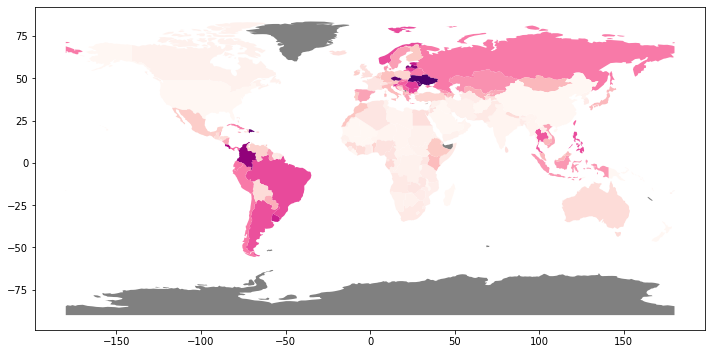

In [23]:
plot_map(keywords, 'percentage_manual_keyword_check', True)

What about the regional distribution?

In [24]:
get_percentages(df, 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='sub_region_name')

,sub_region_name,percentage_manual_keyword_check
3,Eastern Europe,0.372000
4,Latin America and the Caribbean,0.204000
9,Northern Europe,0.195000
13,Southern Europe,0.169333
11,South-eastern Asia,0.160000
1,Central Asia,0.156000
2,Eastern Asia,0.108571
16,Western Europe,0.082462
15,Western Asia,0.062778
7,Northern Africa,0.051429


Now we see that eastern european women are overly sexualized, but that the trend expands to include women from other subregions in similar rates. Northern american and western european women, however, are not very sexualized.

To better understand the dynamics of each region, let's take a loot at them in detail.

#### Eastern europe

In [25]:
get_percentages(df[df.sub_region_name=="Eastern Europe"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
9,Ukraine,0.61
2,Czechia,0.58
5,Republic of Moldova,0.53
6,Romania,0.37
1,Bulgaria,0.36
3,Hungary,0.32
0,Belarus,0.28
7,Russian Federation,0.28
8,Slovakia,0.28
4,Poland,0.11


Here, we see sexualization rates well above 1/4 of the displayed results. The less sexualized country, Poland, is still slightly above the world average for all countries, which is of 10.5%.

#### Northern europe

In [26]:
get_percentages(df[df.sub_region_name=="Northern Europe"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
6,Latvia,0.53
2,Estonia,0.42
7,Lithuania,0.37
9,Norway,0.35
0,Denmark,0.24
11,Sweden,0.23
3,Finland,0.14
5,Ireland,0.13
4,Iceland,0.08
12,United Kingdom of Great Britain and Northern I...,0.08


Notice how the higher rates como mostly from the three former USSR-countries in the Baltic Sea: Latvia, Estonia and Lithuania. Together, they average a 41% rate -- higher than even most Eastern European countries. THere is a significant rate of sexualization, although a bit lower, for nordic countries. 

#### Southern europe

In [27]:
get_percentages(df[df.sub_region_name=="Southern Europe"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
13,Slovenia,0.39
12,Serbia,0.31
3,Croatia,0.26
4,Greece,0.22
14,Spain,0.22
0,Albania,0.19
5,Italy,0.17
9,North Macedonia,0.17
1,Andorra,0.14
10,Portugal,0.14


Again, we see countries that could easily be defined as eastern european making the top of the list, such as Slovenia, Serbia and Croatia and Greece. Albania and North Macedonia are also above the world's average. Bosnia and Herzegovina, Kosovo and Montenegro are exceptions to this rule. Italian and spanish women are also very sexualized.

#### Central asia

In [28]:
get_percentages(df[df.sub_region_name=="Central Asia"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
0,Kazakhstan,0.25
1,Kyrgyzstan,0.21
4,Uzbekistan,0.20
2,Tajikistan,0.08
3,Turkmenistan,0.04


All of those are former Soviet republics. Tajikistan and Turkemnistas are exceptions, below the world's average. The other three, however, are well above this mark.

#### South-eastern Asia


In [29]:
get_percentages(df[df.sub_region_name=="South-eastern Asia"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
6,Philippines,0.35
8,Thailand,0.33
2,Indonesia,0.24
9,Viet Nam,0.22
1,Cambodia,0.18
4,Malaysia,0.18
0,Brunei Darussalam,0.14
7,Singapore,0.08
3,Lao People's Democratic Republic,0.03
5,Myanmar,0.01


Philipinnes, Thailand, Indonesia, Vietnam, Malaysia and Cambodia and Brunei are all above the world average.

#### Eastern Asia

In [30]:
get_percentages(df[df.sub_region_name=="Eastern Asia"], 
                eval_col='manual_keyword_check', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area')

,country_or_area,percentage_manual_keyword_check
5,Taiwan,0.31
2,Japan,0.18
3,Mongolia,0.18
0,"China, Macao Special Administrative Region",0.04
4,Republic of Korea,0.04
1,Democratic People's Republic of Korea,0.01
0,China,0.00


## Association between the two elements

Is the presence of objectifying texts and content linked to the presence of a racy picture?

In [34]:
df["both_bools"] = (df.manual_keyword_check) & (df.racy_bool)

In [35]:
both = get_percentages(df, 
                eval_col='both_bools', 
                condition=lambda x: x is True, # This is simply checking if the boolean is true. We can pass any other condition, though
                group_col='country_or_area',
                join_cols=["iso_a3"])

display(both)

,country_or_area,percentage_both_bools,iso_a3
0,Dominica,0.36,DMA
1,Dominican Republic,0.36,DOM
2,Costa Rica,0.29,CRI
3,Colombia,0.26,COL
4,Brazil,0.26,BRA
5,Republic of Moldova,0.24,MDA
6,Uruguay,0.23,URY
7,Ecuador,0.17,ECU
8,Czechia,0.17,CZE
9,Argentina,0.16,ARG


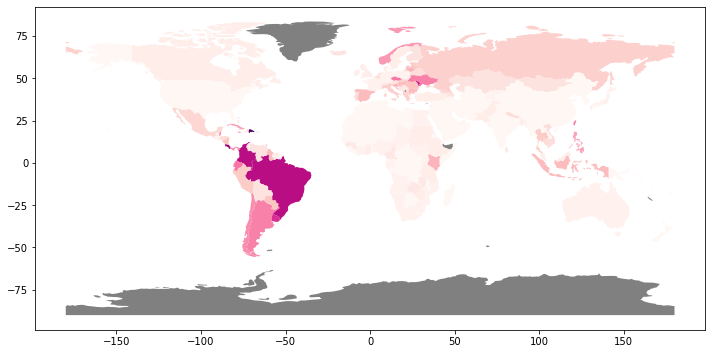

In [36]:
plot_map(both, 'percentage_both_bools', True)

If we look only at search results that have both racy images and links to sexualizing websites, the geographical distribuiton is roughly the same.